<a href="https://colab.research.google.com/github/escuccim/pytorch-face-autoencoder/blob/master/eas7_faces_3g_a.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Adding some longer residual connections to try to preserve some small details which seem to be getting lost; added batch norm; replaced 6x5 convolution with global average pool followed by 1x1 convolution.

Erased some of the training output for version 3.1 to keep size of notebook manageable.

**3.1g** - Now that the autoencoder seems to be close to overfitting the training data, I'm going to try to add an adversarial network to it to see how that works.

Updated training function so that it uses inputs and reconstructions from different batches rather than using the reconstructed and real versions of the same images for each batch. A side effect of this is that the discriminator is trained at most once every other iteration.

20190701 - Added code to only train discriminator when it's accuracy is below a certain threshold. It was getting tiring trying to tune the training so that one wouldn't overload the other one. We'll see how this works.

20190819 - Retraining from scratch as GAN. There were many errors in the code I was previously trying to use AND the discriminator didn't seem to be doing a very good job of doing any useful discrimination, so I decided to start over from scratch with the bugs in the code fixed.

In [1]:
import torch
import torchvision
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
%matplotlib inline
import zipfile
import os

from google.colab import auth
auth.authenticate_user()

# upload checkpoint to GCS
project_id = 'mammography-198911'
bucket_name = 'pneumonia'

!gcloud config set project {project_id}

Updated property [core/project].


To take a quick anonymous survey, run:
  $ gcloud alpha survey



In [2]:
# !gsutil cp gs://{bucket_name}/model_30_trained.pt ./model_3g_e.pt
!gsutil cp gs://{bucket_name}/gen_model_31.pt ./gen_model_3.pt
!gsutil cp gs://{bucket_name}/disc_model_31.pt ./disc_model_3.pt

Copying gs://pneumonia/gen_model_31.pt...
\ [1 files][294.9 MiB/294.9 MiB]                                                
Operation completed over 1 objects/294.9 MiB.                                    
Copying gs://pneumonia/disc_model_31.pt...
/
Operation completed over 1 objects/44.6 MiB.                                     


In [0]:
# if not os.path.exists("celeba-dataset.zip"):
# #   !kaggle datasets download -d jessicali9530/celeba-dataset
#   !gsutil cp gs://{bucket_name}/celeba-dataset.zip ./celeba-dataset.zip
#   zip_ref = zipfile.ZipFile('celeba-dataset.zip', 'r')
#   zip_ref.extractall('data')
#   zip_ref.close()

#   zip_ref = zipfile.ZipFile('data/img_align_celeba.zip', 'r')
#   zip_ref.extractall('data/images')
#   zip_ref.close()
  
# if not os.path.exists("Training_Pictures.zip"):
#   !wget https://s3.eu-west-3.amazonaws.com/deep.skoo.ch/Training_Pictures.zip
#   zip_ref = zipfile.ZipFile('Training_Pictures.zip', 'r')
#   zip_ref.extractall('data/images')
#   zip_ref.close()  

# if not os.path.exists("imdb_images3.zip"):
#   !gsutil cp gs://{bucket_name}/imdb_images3.zip ./imdb_images3.zip
#   zip_ref = zipfile.ZipFile('imdb_images3.zip', 'r')
#   zip_ref.extractall('data/images')
#   zip_ref.close()

# if not os.path.exists("GWB_200x200_JPEG.zip"):
#   !wget https://s3.eu-west-3.amazonaws.com/deep.skoo.ch/GWB_200x200_JPEG.zip
#   zip_ref = zipfile.ZipFile('GWB_200x200_JPEG.zip', 'r')
#   zip_ref.extractall('data/images')               
#   zip_ref.close()  

In [3]:
if not os.path.exists("celeb_a_good.zip"):
#   !kaggle datasets download -d jessicali9530/celeba-dataset
  !gsutil cp gs://{bucket_name}/celeb_a_good.zip ./celeb_a_good.zip
  zip_ref = zipfile.ZipFile('celeb_a_good.zip', 'r')
  zip_ref.extractall('data/images/celeb_a')
  zip_ref.close()

if not os.path.exists("Training_Pictures.zip"):
  !wget https://s3.eu-west-3.amazonaws.com/deep.skoo.ch/Training_Pictures.zip
  zip_ref = zipfile.ZipFile('Training_Pictures.zip', 'r')
  zip_ref.extractall('data/images/training')
  zip_ref.close()
  
# if not os.path.exists("imdb_crop_good.zip"):  
#   !gsutil cp gs://{bucket_name}/imdb_crop_good.zip ./imdb_crop_good.zip
#   zip_ref = zipfile.ZipFile('imdb_crop_good.zip', 'r')
#   zip_ref.extractall('data/images/imdb')
#   zip_ref.close()

# if not os.path.exists("crop_part1_good.zip"):
#   !gsutil cp gs://{bucket_name}/crop_part1_good.zip ./crop_part1_good.zip
#   zip_ref = zipfile.ZipFile('crop_part1_good.zip', 'r')
#   zip_ref.extractall('data/images/crop_parta')
#   zip_ref.close()   

Copying gs://pneumonia/celeb_a_good.zip...
- [1 files][  1.1 GiB/  1.1 GiB]   27.7 MiB/s                                   
Operation completed over 1 objects/1.1 GiB.                                      
--2019-08-25 05:24:25--  https://s3.eu-west-3.amazonaws.com/deep.skoo.ch/Training_Pictures.zip
Resolving s3.eu-west-3.amazonaws.com (s3.eu-west-3.amazonaws.com)... 52.95.156.41
Connecting to s3.eu-west-3.amazonaws.com (s3.eu-west-3.amazonaws.com)|52.95.156.41|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 955202 (933K) [application/zip]
Saving to: ‘Training_Pictures.zip’

Training_Pictures.z 100%[===================>] 932.81K   614KB/s    in 1.5s    

2019-08-25 05:24:28 (614 KB/s) - ‘Training_Pictures.zip’ saved [955202/955202]



In [4]:
# get test data
if not os.path.exists("wiki_images_good.zip"):
  !gsutil cp gs://{bucket_name}/wiki_images_good.zip ./wiki_images_good.zip
  zip_ref = zipfile.ZipFile('wiki_images_good.zip', 'r')
  zip_ref.extractall('data/test_images')
  zip_ref.close()  

if not os.path.exists("faces94.zip"):
  !wget https://cswww.essex.ac.uk/mv/allfaces/faces94.zip
  zip_ref = zipfile.ZipFile('faces94.zip', 'r')
  zip_ref.extractall('data/test_images')
  zip_ref.close()
  
# if not os.path.exists("faces96.zip"):
#   !wget https://cswww.essex.ac.uk/mv/allfaces/faces96.zip  
#   zip_ref = zipfile.ZipFile('faces96.zip', 'r')
#   zip_ref.extractall('data/test_images')
#   zip_ref.close()

if not os.path.exists("faces95.zip"):
  !wget https://cswww.essex.ac.uk/mv/allfaces/faces95.zip  
  zip_ref = zipfile.ZipFile('faces95.zip', 'r')
  zip_ref.extractall('data/test_images')
  zip_ref.close()

# if not os.path.exists("GWB_200x200_JPEG.zip"):
#   !wget https://s3.eu-west-3.amazonaws.com/deep.skoo.ch/GWB_200x200_JPEG.zip
#   zip_ref = zipfile.ZipFile('GWB_200x200_JPEG.zip', 'r')
#   zip_ref.extractall('data/test_images')
#   zip_ref.close()  
  
if not os.path.exists("celeb_a_test.zip"):
  !gsutil cp gs://{bucket_name}/celeb_a_test.zip ./celeb_a_test.zip
  zip_ref = zipfile.ZipFile('celeb_a_test.zip', 'r')
  zip_ref.extractall('data/test_images')
  zip_ref.close()       
  
if not os.path.exists("wiki_crop_test.zip"):
  !gsutil cp gs://{bucket_name}/wiki_crop_test.zip ./wiki_crop_test.zip
  zip_ref = zipfile.ZipFile('wiki_crop_test.zip', 'r')
  zip_ref.extractall('data/test_images')
  zip_ref.close()     
  
if not os.path.exists("imdb_crop_test.zip"):
  !gsutil cp gs://{bucket_name}/imdb_crop_test.zip ./imdb_crop_test.zip
  zip_ref = zipfile.ZipFile('imdb_crop_test.zip', 'r')
  zip_ref.extractall('data/test_images')
  zip_ref.close()
  
if not os.path.exists("crop_part1_test.zip"):
  !gsutil cp gs://{bucket_name}/crop_part1_test.zip ./crop_part1_test.zip
  zip_ref = zipfile.ZipFile('crop_part1_test.zip', 'r')
  zip_ref.extractall('data/test_images')
  zip_ref.close()     

Copying gs://pneumonia/wiki_images_good.zip...
| [1 files][ 94.7 MiB/ 94.7 MiB]                                                
Operation completed over 1 objects/94.7 MiB.                                     
--2019-08-25 05:24:38--  https://cswww.essex.ac.uk/mv/allfaces/faces94.zip
Resolving cswww.essex.ac.uk (cswww.essex.ac.uk)... 155.245.92.179
Connecting to cswww.essex.ac.uk (cswww.essex.ac.uk)|155.245.92.179|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 18845407 (18M) [application/zip]
Saving to: ‘faces94.zip’

faces94.zip         100%[===================>]  17.97M  5.94MB/s    in 3.0s    

2019-08-25 05:24:43 (5.94 MB/s) - ‘faces94.zip’ saved [18845407/18845407]

--2019-08-25 05:24:45--  https://cswww.essex.ac.uk/mv/allfaces/faces95.zip
Resolving cswww.essex.ac.uk (cswww.essex.ac.uk)... 155.245.92.179
Connecting to cswww.essex.ac.uk (cswww.essex.ac.uk)|155.245.92.179|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6425534 (6.

In [0]:
# get test data
# if not os.path.exists("faces94.zip"):
#   !wget https://cswww.essex.ac.uk/mv/allfaces/faces94.zip
#   zip_ref = zipfile.ZipFile('faces94.zip', 'r')
#   zip_ref.extractall('data/test_images')
#   zip_ref.close()
# if not os.path.exists("wiki_images2.zip"):
#   !gsutil cp gs://{bucket_name}/wiki_images2.zip ./wiki_images.zip
#   zip_ref = zipfile.ZipFile('wiki_images.zip', 'r')
#   zip_ref.extractall('data/test_images')
#   zip_ref.close()

# if not os.path.exists("faces96.zip"):
#   !wget https://cswww.essex.ac.uk/mv/allfaces/faces96.zip  
#   zip_ref = zipfile.ZipFile('faces96.zip', 'r')
#   zip_ref.extractall('data/test_images')
#   zip_ref.close()
  
# if not os.path.exists("faces95.zip"):
#   !wget https://cswww.essex.ac.uk/mv/allfaces/faces95.zip  
#   zip_ref = zipfile.ZipFile('faces95.zip', 'r')
#   zip_ref.extractall('data/test_images')
#   zip_ref.close()

# if not os.path.exists("crop_part1.tar.gz"):
#   !gsutil cp gs://{bucket_name}/crop_part1.tar.gz ./crop_part1.tar.gz
#   !tar -xf crop_part1.tar.gz -C data/images

In [0]:
BATCH_SIZE = 18
data_path = "data/images"

transform = torchvision.transforms.Compose(
    [torchvision.transforms.RandomHorizontalFlip(p=0.5), 
      torchvision.transforms.RandomApply([
        torchvision.transforms.RandomAffine(degrees=5, translate=(0.075,0.075), scale=(0.9,1.15), shear=4, resample=False, fillcolor=0),        
      ], 0.7),
      torchvision.transforms.RandomResizedCrop((192,160), scale=(0.8, 1.20)),
      torchvision.transforms.ToTensor(),
    ])

transform2 = torchvision.transforms.Compose(
    [torchvision.transforms.RandomResizedCrop((192,160), scale=(0.95, 1.05)),
      torchvision.transforms.ToTensor(),
    ])

train_dataset = torchvision.datasets.ImageFolder(
        root=data_path,
        transform=transform
    )

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    num_workers=2,
    shuffle=True
)

test_dataset = torchvision.datasets.ImageFolder(
        root="data/test_images",
        transform=transform2
    )

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=48,
    num_workers=1,
    shuffle=True
)

In [0]:
for (images, _) in train_loader:
  plt.imshow(images[0].permute(1,2,0))
  plt.show()
  break

In [0]:
for (images, _) in test_loader:
  plt.imshow(images[0].permute(1,2,0))
  plt.show()
  break

In [6]:
train_dataset

Dataset ImageFolder
    Number of datapoints: 166889
    Root location: data/images

In [7]:
test_dataset

Dataset ImageFolder
    Number of datapoints: 58996
    Root location: data/test_images

In [0]:
def output_size(i, k=3, p=2, s=1, d=1):
    o = (i + 2*p - k - (k-1)*(d-1))/s + 1
    return o
  
output_size(i=64, k=3, p=1)

64.0

### Create Models

In [0]:
epoch_list = []

In [0]:
def vae_loss(x, x_hat, d_faked=None, debug=False):
    beta_mse = 20.0
    beta_kld = 0.1
    beta_gloss = 1.0
    
    # MSE for reconstructions
    MSE = nn.functional.mse_loss(x, x_hat)
    MSE *= beta_mse
    
    # weight the MSE loss higher so the discriminator loss doesn't overwhelm it
    if d_faked is not None:
        ones = torch.ones(d_faked.shape[0]).cuda()
        g_loss =  nn.functional.binary_cross_entropy_with_logits(d_faked, ones, reduction="mean")
        g_loss *= beta_gloss
    else:
        g_loss = torch.zeros(1).cuda()
        
    # print out loss info if we want to debug
    if debug:
        print("MSE Loss Raw:", MSE)
        print("MSE Loss Weighted:", MSE * beta_mse)
        print("KLD Loss Raw:", KLD)
        print("KLD Loss Weighted:", KLD * beta_kld)
        if d_faked is not None:
            print("Disc Loss Raw:", g_loss)
            print("Disc Loss Weighted:", g_loss * beta_gloss)
        print("Total Loss (weighted):", total_loss)
    
    return MSE + g_loss, MSE, 0, g_loss
  
def disc_loss(d_true, d_faked):
    ones = torch.ones(d_true.shape[0]).cuda()
    zeros = torch.zeros(d_true.shape[0]).cuda()
    d_loss_real = nn.functional.binary_cross_entropy_with_logits(d_true, ones, reduction="mean")
    d_loss_fake = nn.functional.binary_cross_entropy_with_logits(d_faked, zeros, reduction="mean")
    d_loss = d_loss_real + d_loss_fake

    return d_loss

def disc_loss2(labels, logits):
    d_loss = nn.functional.binary_cross_entropy_with_logits(logits, labels, reduction="mean")
    
    return d_loss    

  
def train_gan(discriminator, generator, train_loader, d_optimizer, g_optimizer, extra_gen_train=8, test_loader=None, print_metrics=1000, plot_images=4000,
              separate_batches=True, num_epochs=10, g_scheduler=None, d_scheduler=None, d_save_path="disc_model_3.pt",
              g_save_path="gen_model_3.pt"):
    try:
        for epoch in range(num_epochs):
            discriminator.train()
            generator.train()

            d_upload_path = d_save_path.split(".")[0] + str(len(epoch_list) % 2) + ".pt"
            g_upload_path = g_save_path.split(".")[0] + str(len(epoch_list) % 2) + ".pt"

            mse_losses = []
            kld_losses = [0]
            g_tr_losses = []
            d_tr_losses = []

            d_test_loss = 0.0
            g_test_loss = 0.0
            test_losses = []
            test_d_losses = []

            test_d_acc = []
            batch_losses = []
            batch_accuracies = []
            disc_losses = []

            for i, (inputs, _) in enumerate(train_loader):
                # if the batch is too small skip so we don't have problems with batch norm
                if inputs.shape[0] <= 2:
                    continue

                if use_cuda and torch.cuda.is_available():
                    inputs = inputs.cuda()

                # make a batch of half real, half fake images
                batch_size = int(inputs.shape[0] // 2)

                ## Train discriminator
                d_optimizer.zero_grad()

                # make labels for the batch
                if use_cuda and torch.cuda.is_available():
                    ones = torch.ones(batch_size).cuda()
                    zeros = torch.zeros(batch_size).cuda()
                else:
                    ones = torch.ones(batch_size)
                    zeros = torch.zeros(batch_size)

                ## SINGLE BATCHES
                if not separate_batches or i % extra_gen_train == 0:
                  if epoch % extra_gen_train == 0:
                    recon, code, logvar = generator(inputs[-batch_size:])
                    disc_batch = torch.cat((inputs[:batch_size], recon), 0)
                    d_labels = torch.cat((ones, zeros))

                    d_logits = discriminator(disc_batch)
                    d_loss = disc_loss2(d_labels, d_logits)
                    d_loss.backward()
                  else:
                    with torch.no_grad():
                      recon, code, logvar = generator(inputs[-batch_size:])
                      disc_batch = torch.cat((inputs[:batch_size], recon), 0)
                      d_labels = torch.cat((ones, zeros))

                      d_logits = discriminator(disc_batch)
                      d_loss = disc_loss2(d_labels, d_logits)

                  # metrics
                  d_preds = torch.sigmoid(d_logits).round()
                  d_accuracy = torch.mean((d_preds == d_labels).double())
                else:
                    ## SEPARATE BATCHES
                    # feed real images
                    d_real = discriminator(inputs[:batch_size])
                    real_loss = disc_loss2(ones, d_real)
                    real_loss.backward(retain_graph=True)

                    # reconstruct a batch
                    recon, code, logvar = generator(inputs[-batch_size:])
                    # feed the batch to the discriminator
                    d_fake = discriminator(recon.detach())
                    fake_loss = disc_loss2(zeros, d_fake)
                    fake_loss.backward()

                    # add the losses
                    d_loss = real_loss + fake_loss

                    # calculate the accuracy of our discriminator
                    real_preds = torch.sigmoid(d_real).round()
                    real_acc = torch.mean((real_preds == ones).double())
                    fake_preds = torch.sigmoid(d_fake).round()
                    fake_acc = torch.mean((fake_preds == zeros).double())
    
                    # calculate some metrics
                    d_accuracy = (real_acc + fake_acc) / 2
                ## END SEPARATE BATCHES

                batch_accuracies.append(d_accuracy.item())

                d_tr_losses.append(d_loss.item())

                # step the optimizer
                d_optimizer.step()

                ## Train generator
                g_optimizer.zero_grad()
                recon, code, logvar = generator(inputs)

                # get the discriminator logits
                faked_logits = discriminator(recon)

                # get our loss, compute the gradients and step the optimizer
                g_loss, mse, kld, disc_loss = vae_loss(inputs, recon, d_faked=faked_logits)
                g_loss.backward()
                g_optimizer.step()

                # calculate some metrics
                g_tr_losses.append(g_loss.item())
                mse_losses.append(mse.item())
                disc_losses.append(disc_loss.item())

                if i > 0 and print_metrics != 0 and i % print_metrics == 0:
                    print("\tEpoch", len(epoch_list), "batch", i, "gen total loss:",
                          np.mean(g_tr_losses[-print_metrics:]), "mse loss:", np.mean(mse_losses[-print_metrics:]),
                          "kld loss:", np.mean(kld_losses[-print_metrics:]), "xe loss:",
                          np.mean(disc_losses[-print_metrics:]), "disc loss:", np.mean(d_tr_losses[-print_metrics:]),
                          "disc acc:", np.mean(batch_accuracies[-print_metrics:]))

                if i % plot_images == 0 and i > 0:
                    fig, ax = plt.subplots(1, 2, figsize=(6, 6))
                    ax[0].imshow(inputs[0].cpu().permute(1, 2, 0))
                    ax[1].imshow(recon[0].cpu().detach().permute(1, 2, 0))
                    plt.show()

            # plot a few random images
            try:
                fig, ax = plt.subplots(2, 2, figsize=(6, 6))
                fig.suptitle("Training Images")
                ax[0, 0].imshow(inputs[0].cpu().permute(1, 2, 0))
                ax[0, 1].imshow(recon[0].cpu().detach().permute(1, 2, 0))
                ax[1, 0].imshow(inputs[1].cpu().permute(1, 2, 0))
                ax[1, 1].imshow(recon[1].cpu().detach().permute(1, 2, 0))
                plt.show()
            except Exception as e:
                print(e)

            torch.save(discriminator.state_dict(), d_save_path)
            torch.save(generator.state_dict(), g_save_path)

            if test_loader is not None:
                generator.eval()
                discriminator.eval()
                with torch.no_grad():
                    for i, (inputs, _) in enumerate(test_loader):
                        if use_cuda and torch.cuda.is_available():
                            inputs = inputs.cuda()

                        # autoencode the input images
                        recon, code, logvar = generator(inputs)

                        loss, _, _, _ = vae_loss(inputs, recon)
                        test_losses.append(loss.item())

                        # combine the real and recon images into a single batch for the discriminator
                        disc_batch = torch.cat((inputs, recon), 0)

                        # feed the batch to the discriminator
                        d_logits = discriminator(disc_batch)

                        # create labels for the disc loss function
                        batch_size = d_logits.shape[0] // 2
                        if use_cuda:
                            ones = torch.ones(batch_size).cuda()
                            zeros = torch.zeros(batch_size).cuda()
                        else:
                            ones = torch.ones(batch_size)
                            zeros = torch.zeros(batch_size)

                        labels = torch.cat((ones, zeros))

                        # run the discriminator loss function
                        d_loss = disc_loss2(labels, d_logits)
                        test_d_losses.append(d_loss.item())

                        # calculate the accuracy of our discriminator
                        d_preds = torch.sigmoid(d_logits).round()
                        d_accuracy = torch.mean((d_preds == labels).double())
                        test_d_acc.append(d_accuracy.item())

                try:
                    fig, ax = plt.subplots(2, 2, figsize=(6, 6))
                    fig.suptitle("Test Images")
                    ax[0, 0].imshow(inputs[0].cpu().permute(1, 2, 0))
                    ax[0, 1].imshow(recon[0].cpu().detach().permute(1, 2, 0))
                    ax[1, 0].imshow(inputs[1].cpu().permute(1, 2, 0))
                    ax[1, 1].imshow(recon[1].cpu().detach().permute(1, 2, 0))
                    plt.show()
                except Exception as e:
                    print(e)

            print("Epoch:", len(epoch_list), "Gen Train Loss:", np.mean(g_tr_losses), "MSE Loss:", np.mean(mse_losses),
                  "KLD Loss:", np.mean(kld_losses), "Mean GAN XE Loss:", np.mean(disc_losses), "Disc Train Loss:",
                  np.mean(d_tr_losses), "Test Loss:", np.mean(test_losses), "Avg Tr Disc Acc:",
                  np.mean(batch_accuracies), "Avg Te Disc Acc:", np.mean(test_d_acc))

            epoch_list.append(epoch)

            if g_scheduler is not None and epoch % 5 == 0 and epoch > 1:
                g_scheduler.step()

            if d_scheduler is not None and epoch % 5 == 0 and epoch > 1:
                d_scheduler.step()

    except KeyboardInterrupt:
        print("Epoch:", len(epoch_list), "Gen Train Loss:", np.mean(g_tr_losses), "MSE Loss:", np.mean(mse_losses),
              "Mean GAN XE Loss:", np.mean(disc_losses), "Disc Train Loss:", np.mean(d_tr_losses), "Avg Tr Disc Acc:",
              np.mean(batch_accuracies))
        print("Interrupting... Saving model...")
        torch.save(generator.state_dict(), g_save_path)
        torch.save(discriminator.state_dict(), d_save_path)
        !gsutil cp {g_save_path} gs://{bucket_name}/{g_upload_path}
        !gsutil cp {d_save_path} gs://{bucket_name}/{d_upload_path}
        return
    except Exception as e:
        print("Value error... Saving model...")
        print(e)
        torch.save(generator.state_dict(), g_save_path)
        torch.save(discriminator.state_dict(), d_save_path)
        !gsutil cp {g_save_path} gs://{bucket_name}/{g_upload_path}
        !gsutil cp {d_save_path} gs://{bucket_name}/{d_upload_path}
        return

    !gsutil cp {g_save_path} gs://{bucket_name}/{g_upload_path}
    !gsutil cp {d_save_path} gs://{bucket_name}/{d_upload_path}

def train_discriminator(discriminator, generator, train_loader, d_optimizer, g_optimizer, train_gen=True, train_disc=True, always_train_disc=False, extra_gen_train=10, test_loader=None, print_metrics=1000, plot_images=4000, num_epochs=10, display_images=5, g_scheduler=None, d_scheduler=None, d_save_path="disc_model_3.pt", g_save_path="gen_model_3.pt"):
    
    try:
      for epoch in range(num_epochs):
          discriminator.train()
          generator.train()
          
          d_upload_path = d_save_path.split(".")[0] + str(len(epoch_list) % 2) + ".pt" 
          g_upload_path = g_save_path.split(".")[0] + str(len(epoch_list) % 2) + ".pt" 
          
          mse_losses = []
          kld_losses = [0]
          g_tr_losses = []
          d_tr_losses = []
          
          d_test_loss = 0.0
          g_test_loss = 0.0
          test_losses = []
          test_d_losses = []
          
          test_d_acc = []
          batch_losses = []
          batch_accuracies = []
          disc_losses = []
          
          for i, (inputs, _) in enumerate(train_loader):
              # if the batch is too small skip so we don't have problems with batch norm
              if inputs.shape[0] <= 2:
                continue
                
              if use_cuda and torch.cuda.is_available():
                  inputs = inputs.cuda()

              ## Train generator
              if train_gen:
                g_optimizer.zero_grad()
                recon, code, logvar = generator(inputs)
                
                # get the discriminator logits
                faked_logits = discriminator(recon)
                
                # get our loss, compute the gradients and step the optimizer
                g_loss, mse, kld, disc_loss = vae_loss(inputs, recon, d_faked=faked_logits)
                g_loss.backward()
                g_optimizer.step()
                
                # calculate some metrics
                g_tr_losses.append(g_loss.item())
                mse_losses.append(mse.item())
#                 kld_losses.append(kld.item())
                disc_losses.append(disc_loss.item())
                  
              ## Train discriminator
              # make a batch of half real, half fake images
              batch_size = int(inputs.shape[0] // 1.5)

              with torch.no_grad():
                recon, code, logvar = generator(inputs[-batch_size:])

              disc_batch = torch.cat((inputs[:batch_size], recon), 0)

              # make labels for the batch
              if use_cuda and torch.cuda.is_available():
                ones = torch.ones(batch_size).cuda()
                zeros = torch.zeros(batch_size).cuda()
              else:
                ones = torch.ones(batch_size)
                zeros = torch.zeros(batch_size)

              labels = torch.cat((ones, zeros))
              
              # when to train the discriminator
              #   - if we aren't training the generator always train it
              #   - if always_train_disc is True OR it is the correct batch OR the batch accuracy is below a certain amount
              if (train_disc or not train_gen) and (always_train_disc or i % extra_gen_train == 0 or (not always_train_disc and (np.mean(batch_accuracies) <= 0.97 or np.mean(batch_accuracies[-3:]) <= 0.93))):
                d_optimizer.zero_grad()
              
              # feed the batch to the discriminator
                d_logits = discriminator(disc_batch)
                
                # get the loss
                d_loss = disc_loss2(labels, d_logits)
                
                # calculate gradients and step the optimizer
                d_loss.backward(retain_graph=True)
                d_optimizer.step()
                
                
              # if we are not training the discriminator we will still run the stuff through it for metrics
              else:
                with torch.no_grad():
                  d_logits = discriminator(disc_batch)
                
                  # get the loss
                  d_loss = disc_loss2(labels, d_logits)
              
              # calculate the accuracy of our discriminator
              d_preds = torch.sigmoid(d_logits).round()

              # calculate some metrics
              d_accuracy = torch.mean((d_preds == labels).double())
              batch_accuracies.append(d_accuracy.item())
              d_tr_losses.append(d_loss.item())
              batch_losses.append(g_loss.item())                
              
              if i > 0 and print_metrics != 0 and i % print_metrics == 0:
                print("\tEpoch", len(epoch_list), "batch", i, "gen total loss:", np.mean(g_tr_losses[-print_metrics:]), "mse loss:", np.mean(mse_losses[-print_metrics:]), "kld loss:", np.mean(kld_losses[-print_metrics:]), "xe loss:", np.mean(disc_losses[-print_metrics:]), "disc loss:", np.mean(d_tr_losses[-print_metrics:]), "disc acc:", np.mean(batch_accuracies[-print_metrics:]))

              if i % plot_images == 0 and i > 0:
                fig, ax = plt.subplots(1, 2, figsize=(6,6))
                ax[0].imshow(inputs[0].cpu().permute(1, 2, 0) )
                ax[1].imshow(recon[0].cpu().detach().permute(1, 2, 0) )
                plt.show()
          
          # plot a few random images
          try:
            fig, ax = plt.subplots(2, 2, figsize=(6,6))
            fig.suptitle("Training Images")
            ax[0,0].imshow(inputs[0].cpu().permute(1, 2, 0) )
            ax[0,1].imshow(recon[0].cpu().detach().permute(1, 2, 0) )
            ax[1,0].imshow(inputs[1].cpu().permute(1, 2, 0) )
            ax[1,1].imshow(recon[1].cpu().detach().permute(1, 2, 0) )
            plt.show()
          except Exception as e:
              print(e)

          torch.save(discriminator.state_dict(), d_save_path)
          torch.save(generator.state_dict(), g_save_path)

          if test_loader is not None:
            generator.eval()
            discriminator.eval()
            with torch.no_grad():
              for i, (inputs, _) in enumerate(test_loader):
                if use_cuda and torch.cuda.is_available():
                  inputs = inputs.cuda()
                
                # autoencode the input images
                recon, code, logvar = generator(inputs)

                loss, _, _, _ = vae_loss(inputs, recon)
                test_losses.append(loss.item())
                
                # combine the real and recon images into a single batch for the discriminator
                disc_batch = torch.cat((inputs, recon), 0)

                # feed the batch to the discriminator
                d_logits = discriminator(disc_batch)
                
                # create labels for the disc loss function
                batch_size = d_logits.shape[0] // 2
                if use_cuda:
                    ones = torch.ones(batch_size).cuda()
                    zeros = torch.zeros(batch_size).cuda()
                else:
                    ones = torch.ones(batch_size)
                    zeros = torch.zeros(batch_size)

                labels = torch.cat((ones, zeros))
                
                # run the discriminator loss function
                d_loss = disc_loss2(labels, d_logits)
                test_d_loss += d_loss.item()
                
                # calculate the accuracy of our discriminator
                d_preds = torch.sigmoid(d_logits).round()
                d_accuracy = torch.mean((d_preds == labels).double())
                test_d_acc.append(d_accuracy.item())
                
            try:
                fig, ax = plt.subplots(2, 2, figsize=(6,6))
                fig.suptitle("Test Images")
                ax[0,0].imshow(inputs[0].cpu().permute(1, 2, 0) )
                ax[0,1].imshow(recon[0].cpu().detach().permute(1, 2, 0) )
                ax[1,0].imshow(inputs[1].cpu().permute(1, 2, 0) )
                ax[1,1].imshow(recon[1].cpu().detach().permute(1, 2, 0) )
                plt.show()
            except Exception as e:
                print(e)
                  
          print("Epoch:", len(epoch_list), "Gen Train Loss:", np.mean(g_tr_losses), "MSE Loss:", np.mean(mse_losses), "KLD Loss:", np.mean(kld_losses), "Mean GAN XE Loss:", np.mean(disc_losses),"Disc Train Loss:", np.mean(d_tr_losses), "Test Loss:", np.mean(test_losses), "Avg Tr Disc Acc:", np.mean(batch_accuracies), "Avg Te Disc Acc:", np.mean(test_d_acc))
          
          epoch_list.append(epoch)
          
          if g_scheduler is not None and len(epoch_list) % 2 == 0 and epoch > 1:
              g_scheduler.step()

          if d_scheduler is not None and len(epoch_list) % 2 and epoch > 1:
              d_scheduler.step()
 
    except KeyboardInterrupt:
      print("Interrupting... Saving model...")
      torch.save(generator.state_dict(), g_save_path)
      torch.save(discriminator.state_dict(), d_save_path)
      !gsutil cp {g_save_path} gs://{bucket_name}/{g_upload_path}
      !gsutil cp {d_save_path} gs://{bucket_name}/{d_upload_path}
      return 
    except Exception as e:
      print("Error... Saving model...")
      print(e)
      torch.save(generator.state_dict(), g_save_path)
      torch.save(discriminator.state_dict(), d_save_path)
      !gsutil cp {g_save_path} gs://{bucket_name}/{g_upload_path}
      !gsutil cp {d_save_path} gs://{bucket_name}/{d_upload_path}
      return 
    
    !gsutil cp {g_save_path} gs://{bucket_name}/{g_upload_path}
    !gsutil cp {d_save_path} gs://{bucket_name}/{d_upload_path}

    
def train(model, train_loader, optimizer, test_loader=None, print_metrics=1000, plot_images=4000, num_epochs=10, display_images=5, scheduler=None, save_path="model_6.pt"):
    try:
      for epoch in range(num_epochs):
          model.train()
          upload_path = save_path.split(".")[0] + str(len(epoch_list) % 2) + ".pt" 
          
          tr_losses = []
          test_losses = []
          for i, (inputs, _) in enumerate(train_loader):
              if use_cuda and torch.cuda.is_available():
                  inputs = inputs.cuda()

              optimizer.zero_grad()

              recon, code, logvar = model(inputs)
              if model.variational:
                  loss, _, _, _ = vae_loss(inputs, recon)
              else:  
                  loss, _, _, _ = vae_loss(inputs, recon)

              loss.backward()
              optimizer.step()

              tr_losses.append(loss.item())
            
              if i > 0 and print_metrics != 0 and i % print_metrics == 0:
                print("\tEpoch", len(epoch_list), "batch", i, "loss:", np.mean(tr_losses[-print_metrics:]))

              if i % plot_images == 0 and i > 0:
                fig, ax = plt.subplots(1, 2, figsize=(6,6))
                ax[0].imshow(inputs[0].cpu().permute(1, 2, 0) )
                ax[1].imshow(recon[0].cpu().detach().permute(1, 2, 0) )
                plt.show()
          
          if epoch % display_images == 0:
              # plot a few random images
              try:
                fig, ax = plt.subplots(2, 2, figsize=(6,6))
                fig.suptitle("Training Images")
                ax[0,0].imshow(inputs[0].cpu().permute(1, 2, 0) )
                ax[0,1].imshow(recon[0].cpu().detach().permute(1, 2, 0) )
                ax[1,0].imshow(inputs[1].cpu().permute(1, 2, 0) )
                ax[1,1].imshow(recon[1].cpu().detach().permute(1, 2, 0) )
                plt.show()
              except Exception as e:
                  print(e)

              torch.save(model.state_dict(), save_path)
#               !gsutil cp ./model.pt gs://{bucket_name}/
          
          if test_loader is not None:
            model.eval()
            with torch.no_grad():
              for i, (inputs, _) in enumerate(test_loader):
                if use_cuda and torch.cuda.is_available():
                    inputs = inputs.cuda()

                recon, code, logvar = model(inputs)

                if model.variational:
                    loss, _, _, _ = vae_loss(inputs, recon, code, logvar=logvar)
                else:  
                    loss, _, _, _ = vae_loss(inputs, recon, code, logvar=None)

                test_losses.append(loss.item())

            try:
                fig, ax = plt.subplots(2, 2, figsize=(6,6))
                fig.suptitle("Test Images")
                ax[0,0].imshow(inputs[0].cpu().permute(1, 2, 0) )
                ax[0,1].imshow(recon[0].cpu().detach().permute(1, 2, 0) )
                ax[1,0].imshow(inputs[1].cpu().permute(1, 2, 0) )
                ax[1,1].imshow(recon[1].cpu().detach().permute(1, 2, 0) )
                plt.show()
            except Exception as e:
                print(e)
                  
          print("Epoch:", len(epoch_list), "Train Loss:", np.mean(tr_losses), "Test Loss:", np.mean(test_loss))
          
          epoch_list.append(epoch)
          
          if scheduler is not None and epoch % 5 == 0 and epoch > 1:
              scheduler.step()

                
    except KeyboardInterrupt:
      print("Interrupting... Saving model...")
      torch.save(model.state_dict(), save_path)
      !gsutil cp {save_path} gs://{bucket_name}/{upload_path}
      return 
    
    !gsutil cp {save_path} gs://{bucket_name}/{upload_path}
      
def count_params(model):
  model_parameters = filter(lambda p: p.requires_grad, model.parameters())
  params = sum([np.prod(p.size()) for p in model_parameters])
  return params               

In [0]:
from torch import nn
class Encoder(nn.Module):
    def __init__(self, latent_dim, variational=False):
        super(Encoder, self).__init__()
        # block 1
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 32, 3, padding=1)        
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 32, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(32)
        self.downsize1 = nn.Conv2d(96, 32, 1)
        self.bn_ds1 = nn.BatchNorm2d(32)
        
        # block 2
        self.conv4 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn4 = nn.BatchNorm2d(64)
        self.conv5 = nn.Conv2d(64, 64, 3, padding=1)
        self.bn5 = nn.BatchNorm2d(64)
        
        self.conv6 = nn.Conv2d(64, 64, 3, padding=1)
        self.bn6 = nn.BatchNorm2d(64)
        self.downsize2 = nn.Conv2d(192, 64, 1)
        self.bn_ds2 = nn.BatchNorm2d(64)
        
        # block 3
        self.conv7 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn7 = nn.BatchNorm2d(128)
        self.conv8 = nn.Conv2d(128, 128, 3, padding=1)
        self.bn8 = nn.BatchNorm2d(128)
        self.conv9 = nn.Conv2d(128, 128, 3, padding=1)
        self.bn9 = nn.BatchNorm2d(128)
        self.downsize3 = nn.Conv2d(384, 128, 1)
        self.bn_ds3 = nn.BatchNorm2d(128)
        
        # block 4
        self.conv10 = nn.Conv2d(128, 256, 3, padding=1)
        self.bn10 = nn.BatchNorm2d(256)
        self.conv11 = nn.Conv2d(256, 256, 3, padding=1)
        self.bn11 = nn.BatchNorm2d(256)
        self.downsize4 = nn.Conv2d(512, 256, 1)
        self.bn_ds4 = nn.BatchNorm2d(256)
        
        # block 5
        self.conv12 = nn.Conv2d(256, 384, 3, padding=1)
        self.bn12 = nn.BatchNorm2d(384)
        self.conv13 = nn.Conv2d(384, 384, 3, padding=1)
        self.bn13 = nn.BatchNorm2d(384)
        self.downsize5 = nn.Conv2d(768, 384, 1)
        self.bn_ds5 = nn.BatchNorm2d(384)
        
        # second path - skip from block 2 on
        self.conv14 = nn.Conv2d(64, 128, 3, padding=1, stride=2)
        self.bn14 = nn.BatchNorm2d(128)
        self.conv15 = nn.Conv2d(128, 128, 3, padding=1, stride=2)
        self.bn15 = nn.BatchNorm2d(128)
        
        self.fc1 = nn.Conv2d(512, latent_dim, 2) # code layer
        
        self.variational = variational
        if variational:
            self.fc2 = nn.Conv2d(512, latent_dim, 2) # variance layer
        
        self.relu = nn.ReLU()
        self.max_pool = nn.MaxPool2d(2,2)
        self.gap = nn.AdaptiveMaxPool2d(2)
        
    def encode(self, x):
        # input 192x160x3 - output 96x80x32
        h1 = self.relu(self.bn1(self.conv1(x)))
        h2 = self.relu(self.bn2(self.conv2(h1)))
        h3 = self.relu(self.bn3(self.conv3(h2)))
        ds1 = self.relu(self.bn_ds1(self.downsize1(torch.cat((h1,h2,h3), 1))))
        mp1 = self.max_pool(ds1)
        
        # input 89x89x32 - output 64x48x40
        h4 = self.relu(self.bn4(self.conv4(mp1)))
        h5 = self.relu(self.bn5(self.conv5(h4)))
        h6 = self.relu(self.bn6(self.conv6(h5)))
        ds2 = self.relu(self.bn_ds2(self.downsize2(torch.cat((h4,h5,h6), 1))))
        mp2 = self.max_pool(ds2)
        
        # input 54x44x64 - output 128x24x20
        h7 = self.relu(self.bn7(self.conv7(mp2)))
        h8 = self.relu(self.bn8(self.conv8(h7)))
        h9 = self.relu(self.bn9(self.conv9(h8)))
        ds3 = self.relu(self.bn_ds3(self.downsize3(torch.cat((h7,h8,h9), 1))))
        mp3 = self.max_pool(ds3)
        
        # input 128x22x22 - output 256x12x10
        h10 = self.relu(self.bn10(self.conv10(mp3)))
        h11 = self.relu(self.bn11(self.conv11(h10)))
        ds4 = self.relu(self.bn_ds4(self.downsize4(torch.cat((h10,h11), 1))))
        mp4 = self.max_pool(ds4)
        
        # input 256x11x11 - output 384x6x5
        h12 = self.relu(self.bn12(self.conv12(mp4)))
        h13 = self.relu(self.bn13(self.conv13(h12)))
        ds5 = self.relu(self.bn_ds5(self.downsize5(torch.cat((h12,h13), 1))))
        mp5 = self.max_pool(ds5)
        
        # second path - input 64x48x40
        # output 64x12x10
        h14 = self.relu(self.bn14(self.conv14(mp2)))
        h15 = self.relu(self.bn15(self.conv15(h14)))
        # output 64x6x5
        mp6 = self.max_pool(h15)
        
        # concat the paths
        concat = self.gap(torch.cat((mp5, mp6), 1))
        
        # input 4x4x64 - output latent_dimx1
        code = self.fc1(concat)
        
        if self.variational:
            logvar = self.fc2(concat)
        else:
            logvar = None
  
        return code, logvar
  
    def forward(self, x):
        code, logvar = self.encode(x)
        return code, logvar

class Decoder(nn.Module):
    def __init__(self, latent_dim):
        super(Decoder, self).__init__()
        self.fc1 = nn.ConvTranspose2d(latent_dim, 512, (6,5), stride=1)
        self.bn0 = nn.BatchNorm2d(512)
        self.deconv1 = nn.ConvTranspose2d(512, 384, 2, stride=2, output_padding=0)
        self.bn1 = nn.BatchNorm2d(384)
        self.deconv3 = nn.ConvTranspose2d(384, 256, 2, stride=2, output_padding=0)
        self.bn3 = nn.BatchNorm2d(256)
        self.deconv4 = nn.ConvTranspose2d(256, 224, 2, stride=2, output_padding=0)
        self.bn4 = nn.BatchNorm2d(224)
        self.deconv5 = nn.ConvTranspose2d(224, 192, 2, stride=2, output_padding=0)
        self.bn5 = nn.BatchNorm2d(192)
        self.deconv6 = nn.ConvTranspose2d(192, 128, 2, stride=2, output_padding=0)
        self.bn6 = nn.BatchNorm2d(128)
        self.deconv8 = nn.Conv2d(128, 3, 1, stride=1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
  
    def decode(self, x):
        # input latent_dimx1 - output 2048x1
        h0 = self.relu(self.bn0(self.fc1(x)))
        
        # in 5x5 - out 10x10
        h1 = self.relu(self.bn1(self.deconv1(h0)))
        
        # in 10x10 - out 20x20
        h3 = self.relu(self.bn3(self.deconv3(h1)))
        h4 = self.relu(self.bn4(self.deconv4(h3)))
        h5 = self.relu(self.bn5(self.deconv5(h4)))
        h6 = self.relu(self.bn6(self.deconv6(h5)))
        h8 = self.deconv8(h6)
      
        return self.sigmoid(h8)
    
    def forward(self, x):
        return self.decode(x)
    
# a model that uses the Encoder and Decoder
class SingleModel(nn.Module):
    def __init__(self, encoder, decoder, variational=False):
        super(SingleModel, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.variational = variational

    def sample(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        eps = torch.autograd.Variable(std.data.new(std.size()).normal_())
        return eps.mul(std).add_(mu)

    def forward(self, X):
        mu, logvar = encoder(X)

        if self.training and logvar is not None:
            z = self.sample(mu, logvar)
        else:
            z = mu
            
        recon = self.decoder(z)
        
        return recon, mu, logvar
    
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        # block 1
        self.conv1 = nn.Conv2d(3, 48, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(48)
        self.conv2 = nn.Conv2d(48, 48, 3, padding=1)        
        self.bn2 = nn.BatchNorm2d(48)
        self.conv3 = nn.Conv2d(48, 48, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(48)
        
        # block 2
        self.conv4 = nn.Conv2d(48, 96, 3, padding=1)
        self.bn4 = nn.BatchNorm2d(96)
        self.conv5 = nn.Conv2d(96, 96, 3, padding=1)
        self.bn5 = nn.BatchNorm2d(96)
        self.conv6 = nn.Conv2d(96, 96, 3, padding=1)
        self.bn6 = nn.BatchNorm2d(96)
        
        # block 3
        self.conv7 = nn.Conv2d(96, 192, 3, padding=1)
        self.bn7 = nn.BatchNorm2d(192)
        self.conv8 = nn.Conv2d(192, 192, 3, padding=1)
        self.bn8 = nn.BatchNorm2d(192)
        self.conv9 = nn.Conv2d(192, 192, 3, padding=1)
        self.bn9 = nn.BatchNorm2d(192)
        
        # block 4
        self.conv10 = nn.Conv2d(192, 384, 3, padding=1)
        self.bn10 = nn.BatchNorm2d(384)
        self.conv11 = nn.Conv2d(384, 384, 3, padding=1)
        self.bn11 = nn.BatchNorm2d(384)
        
        # block 5
        self.conv12 = nn.Conv2d(384, 512, 3, padding=1)
        self.bn12 = nn.BatchNorm2d(512)
        self.conv13 = nn.Conv2d(512, 1024, 3, padding=1)
        self.bn13 = nn.BatchNorm2d(1024)
        
        self.fc1 = nn.Conv2d(1024, 2048, 1) # code layer
        self.bn14 = nn.BatchNorm2d(2048)
        self.fc2 = nn.Conv2d(2048, 1, 1)
        
        self.relu = nn.LeakyReLU(0.2)
        self.max_pool = nn.MaxPool2d(2,2)
        self.gap = nn.AdaptiveMaxPool2d(1)
        
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.50)
        
    def discriminate(self, x):
        # input 192x160x3 - output 96x80x32
        h1 = self.relu(self.bn1(self.conv1(x)))
        h2 = self.relu(self.bn2(self.conv2(h1)))
        h3 = self.relu(self.bn3(self.conv3(h2)))
        mp1 = self.max_pool(h3)
        
        # input 89x89x32 - output 64x48x40
        h4 = self.relu(self.bn4(self.conv4(mp1)))
        h5 = self.relu(self.bn5(self.conv5(h4)))
        h6 = self.relu(self.bn6(self.conv6(h5)))
        mp2 = self.max_pool(h6)
        
        # input 54x44x64 - output 128x24x20
        h7 = self.relu(self.bn7(self.conv7(mp2)))
        h8 = self.relu(self.bn8(self.conv8(h7)))
        h9 = self.relu(self.bn9(self.conv9(h8)))
        mp3 = self.max_pool(h9)
        
        # input 128x22x22 - output 256x12x10
        h10 = self.relu(self.bn10(self.conv10(mp3)))
        h11 = self.relu(self.bn11(self.conv11(h10)))
        mp4 = self.max_pool(h11)
        
        # input 256x11x11 - output 384x6x5
        h12 = self.relu(self.bn12(self.conv12(mp4)))
        h13 = self.relu(self.bn13(self.conv13(h12)))
        mp5 = self.max_pool(h13)
        gap = self.dropout1(self.gap(mp5))
        
        # input 4x4x64 - output latent_dimx1
        fc1 = self.dropout2(self.relu(self.bn14(self.fc1(gap))))
        logits = self.fc2(fc1)
        
        return torch.squeeze(logits)
  
    def forward(self, x):
        return self.discriminate(x)

In [11]:
from torch import optim
import numpy as np

## YOUR CODE HERE ##
encoder = Encoder(4096, variational=False)
decoder = Decoder(4096)
generator = SingleModel(encoder, decoder)
discriminator = Discriminator()

params = generator.parameters()

print("Autoencoder Params:", count_params(generator))
print("Discriminator Params:", count_params(discriminator))

# run on GPU
use_cuda = True
  
if use_cuda and torch.cuda.is_available():
    generator.cuda()
    discriminator.cuda()
    
g_optimizer = optim.Adam(generator.parameters(), lr=0.001)
d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0001)
g_scheduler = optim.lr_scheduler.ExponentialLR(g_optimizer, gamma=0.95)
d_scheduler = optim.lr_scheduler.ExponentialLR(d_optimizer, gamma=0.95)

try:
  generator.load_state_dict(torch.load("gen_model_3.pt"))
  print("Generator loaded")
except:
  print("Error loading Generator")

try:
    discriminator.load_state_dict(torch.load("disc_model_3.pt"))
    print("Discriminator loaded")
except:
    print("Error loading discriminator")

Autoencoder Params: 77289667
Discriminator Params: 11673569
Generator loaded
Discriminator loaded


	Epoch 0 batch 250 gen total loss: 1.164893129825592 mse loss: 0.2604838891029358 kld loss: 0.0 xe loss: 0.9044092390537262 disc loss: 1.7095261821746826 disc acc: 0.5157777816206217
	Epoch 0 batch 500 gen total loss: 1.0148935835361481 mse loss: 0.23422361367940903 kld loss: 0.0 xe loss: 0.7806699705123902 disc loss: 1.5684446935653686 disc acc: 0.49088889254629614
	Epoch 0 batch 750 gen total loss: 0.9696088650226593 mse loss: 0.20280645281076431 kld loss: 0.0 xe loss: 0.7668024139404297 disc loss: 1.5369721970558166 disc acc: 0.5060000037699938
	Epoch 0 batch 1000 gen total loss: 0.9507708630561829 mse loss: 0.1903884087204933 kld loss: 0.0 xe loss: 0.760382455945015 disc loss: 1.5728491191864014 disc acc: 0.48400000360608103


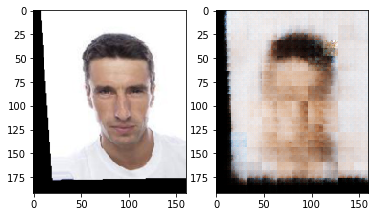

	Epoch 0 batch 1250 gen total loss: 0.96505633187294 mse loss: 0.19319020742177964 kld loss: 0.0 xe loss: 0.7718661262989044 disc loss: 1.522520767211914 disc acc: 0.508000003784895
	Epoch 0 batch 1500 gen total loss: 0.9263724384307861 mse loss: 0.17322380596399306 kld loss: 0.0 xe loss: 0.7531486303806305 disc loss: 1.522683069229126 disc acc: 0.4933333370089531
	Epoch 0 batch 1750 gen total loss: 0.9118632793426513 mse loss: 0.158564505815506 kld loss: 0.0 xe loss: 0.7532987720966339 disc loss: 1.50562633562088 disc acc: 0.4984444481581449
	Epoch 0 batch 2000 gen total loss: 0.9049460890293122 mse loss: 0.15574550879001617 kld loss: 0.0 xe loss: 0.7492005784511566 disc loss: 1.491667703151703 disc acc: 0.48933333697915077


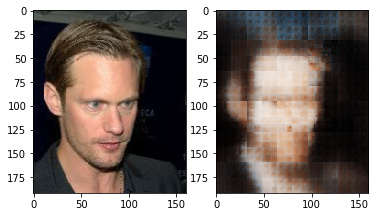

	Epoch 0 batch 2250 gen total loss: 0.9072071747779846 mse loss: 0.1522347865998745 kld loss: 0.0 xe loss: 0.7549723901748657 disc loss: 1.5207401418685913 disc acc: 0.4833333369344473
	Epoch 0 batch 2500 gen total loss: 0.8923892066478729 mse loss: 0.14327025905251503 kld loss: 0.0 xe loss: 0.7491189465522766 disc loss: 1.4832950491905212 disc acc: 0.5060000037699938
	Epoch 0 batch 2750 gen total loss: 0.8905944919586182 mse loss: 0.146507754355669 kld loss: 0.0 xe loss: 0.7440867381095886 disc loss: 1.4764809036254882 disc acc: 0.5037777815312147
	Epoch 0 batch 3000 gen total loss: 0.8925269544124603 mse loss: 0.153005135089159 kld loss: 0.0 xe loss: 0.7395218214988708 disc loss: 1.468634663105011 disc acc: 0.508000003784895


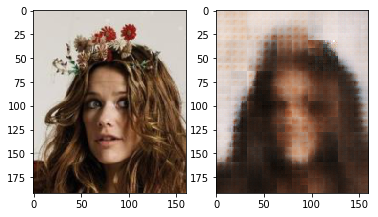

	Epoch 0 batch 3250 gen total loss: 0.8798672873973846 mse loss: 0.14258808994293212 kld loss: 0.0 xe loss: 0.7372791969776153 disc loss: 1.4766011786460878 disc acc: 0.5073333371132612
	Epoch 0 batch 3500 gen total loss: 0.8767652425765992 mse loss: 0.13648916140198708 kld loss: 0.0 xe loss: 0.7402760801315308 disc loss: 1.4570694746971131 disc acc: 0.5013333370685578
	Epoch 0 batch 3750 gen total loss: 0.8651183156967163 mse loss: 0.13001560911536217 kld loss: 0.0 xe loss: 0.735102707862854 disc loss: 1.469527244567871 disc acc: 0.493555559232831
	Epoch 0 batch 4000 gen total loss: 0.871000727891922 mse loss: 0.13004583355784416 kld loss: 0.0 xe loss: 0.7409548952579498 disc loss: 1.4505075063705444 disc acc: 0.5040000037550926


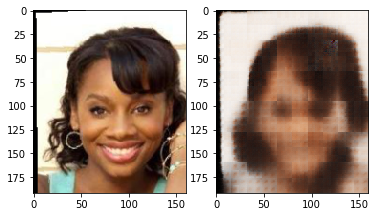

	Epoch 0 batch 4250 gen total loss: 0.8767504231929779 mse loss: 0.13308472150564193 kld loss: 0.0 xe loss: 0.7436657021045685 disc loss: 1.4566090159416198 disc acc: 0.5068888926655054
	Epoch 0 batch 4500 gen total loss: 0.8694688868522644 mse loss: 0.1323579455912113 kld loss: 0.0 xe loss: 0.7371109411716461 disc loss: 1.4487101554870605 disc acc: 0.5068888926655054
	Epoch 0 batch 4750 gen total loss: 0.8707262263298035 mse loss: 0.131895831823349 kld loss: 0.0 xe loss: 0.7388303961753845 disc loss: 1.442564760684967 disc acc: 0.503333337083459
	Epoch 0 batch 5000 gen total loss: 0.8585886433124542 mse loss: 0.13252393916249275 kld loss: 0.0 xe loss: 0.726064701795578 disc loss: 1.4504097137451173 disc acc: 0.5044444482028484


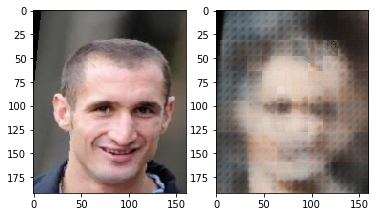

	Epoch 0 batch 5250 gen total loss: 0.8626424760818482 mse loss: 0.13202238032221794 kld loss: 0.0 xe loss: 0.7306200957298279 disc loss: 1.4512256345748902 disc acc: 0.49755555926263334
	Epoch 0 batch 5500 gen total loss: 0.8508563454151153 mse loss: 0.12868765631318094 kld loss: 0.0 xe loss: 0.7221686897277833 disc loss: 1.4504472093582153 disc acc: 0.49422222590446474
	Epoch 0 batch 5750 gen total loss: 0.8507752878665924 mse loss: 0.13097211083769797 kld loss: 0.0 xe loss: 0.7198031759262085 disc loss: 1.4404145650863647 disc acc: 0.5066666704416275
	Epoch 0 batch 6000 gen total loss: 0.8562252452373504 mse loss: 0.12615333393216133 kld loss: 0.0 xe loss: 0.7300719125270844 disc loss: 1.4416752920150757 disc acc: 0.49777778148651125


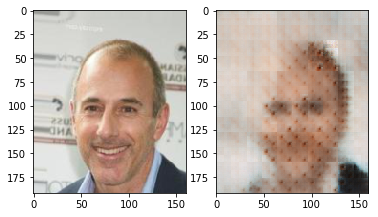

	Epoch 0 batch 6250 gen total loss: 0.858365752696991 mse loss: 0.12895696461200715 kld loss: 0.0 xe loss: 0.7294087891578674 disc loss: 1.4374470443725587 disc acc: 0.4844444480538368
	Epoch 0 batch 6500 gen total loss: 0.8398469393253326 mse loss: 0.12137238785624505 kld loss: 0.0 xe loss: 0.7184745507240295 disc loss: 1.4345677480697632 disc acc: 0.503111114859581
	Epoch 0 batch 6750 gen total loss: 0.8560687546730041 mse loss: 0.1246613478064537 kld loss: 0.0 xe loss: 0.7314074070453643 disc loss: 1.4301843485832215 disc acc: 0.5066666704416275
	Epoch 0 batch 7000 gen total loss: 0.8575656068325043 mse loss: 0.13204158863425255 kld loss: 0.0 xe loss: 0.7255240194797515 disc loss: 1.4259729175567626 disc acc: 0.49466667035222056


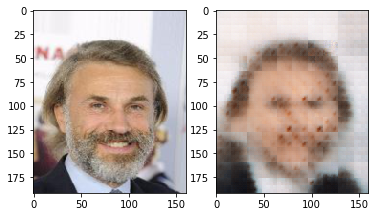

	Epoch 0 batch 7250 gen total loss: 0.8557743804454804 mse loss: 0.1354567681849003 kld loss: 0.0 xe loss: 0.7203176107406616 disc loss: 1.4310742797851563 disc acc: 0.5004444481730461
	Epoch 0 batch 7500 gen total loss: 0.8522717905044556 mse loss: 0.13517978423833846 kld loss: 0.0 xe loss: 0.7170920040607452 disc loss: 1.4199021391868591 disc acc: 0.5011111148446799
	Epoch 0 batch 7750 gen total loss: 0.8421120655536651 mse loss: 0.12388971269130707 kld loss: 0.0 xe loss: 0.7182223534584046 disc loss: 1.4151524109840392 disc acc: 0.49777778148651125
	Epoch 0 batch 8000 gen total loss: 0.8430798118114471 mse loss: 0.1277457519173622 kld loss: 0.0 xe loss: 0.7153340592384339 disc loss: 1.4225458664894104 disc acc: 0.5026666704118252


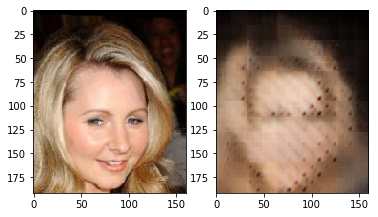

	Epoch 0 batch 8250 gen total loss: 0.8426523001194001 mse loss: 0.1240590616464615 kld loss: 0.0 xe loss: 0.7185932397842407 disc loss: 1.4140339336395265 disc acc: 0.512666670486331
	Epoch 0 batch 8500 gen total loss: 0.8549012408256531 mse loss: 0.13123134285211563 kld loss: 0.0 xe loss: 0.7236698985099792 disc loss: 1.4143654775619507 disc acc: 0.5104444482475519
	Epoch 0 batch 8750 gen total loss: 0.8455181810855865 mse loss: 0.13078509920835496 kld loss: 0.0 xe loss: 0.7147330813407898 disc loss: 1.416236035823822 disc acc: 0.505555559322238
	Epoch 0 batch 9000 gen total loss: 0.8446207501888275 mse loss: 0.12285417270660401 kld loss: 0.0 xe loss: 0.7217665767669678 disc loss: 1.4152661595344544 disc acc: 0.5011111148446799


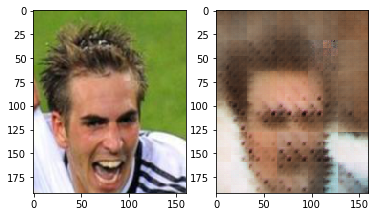

	Epoch 0 batch 9250 gen total loss: 0.8442945520877838 mse loss: 0.12492332017421723 kld loss: 0.0 xe loss: 0.719371232509613 disc loss: 1.4192923340797425 disc acc: 0.49200000366568564


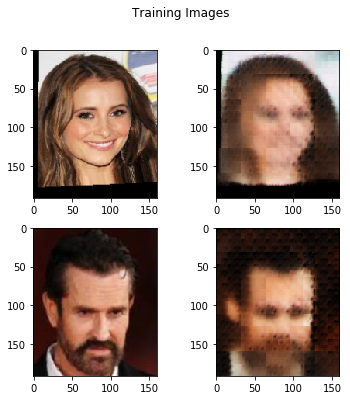

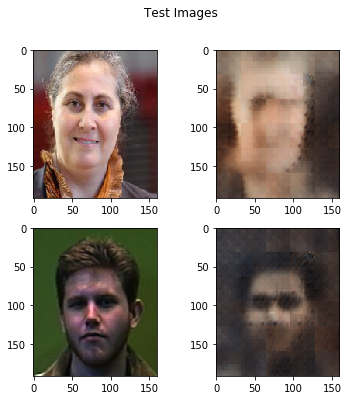

Epoch: 0 Gen Train Loss: 0.8869290052237337 MSE Loss: 0.14626535558486495 KLD Loss: 0.0 Mean GAN XE Loss: 0.740663649718421 Disc Train Loss: 1.4678897365631987 Test Loss: 0.13846792874215352 Avg Tr Disc Acc: 0.5006171545307887 Avg Te Disc Acc: 0.5058381914357107
Copying file://gen_model_3.pt [Content-Type=application/octet-stream]...
==> NOTE: You are uploading one or more large file(s), which would run
significantly faster if you enable parallel composite uploads. This
feature can be enabled by editing the
"parallel_composite_upload_threshold" value in your .boto
configuration file. However, note that if you do this large files will
be uploaded as `composite objects
<https://cloud.google.com/storage/docs/composite-objects>`_,which
means that any user who downloads such objects will need to have a
compiled crcmod installed (see "gsutil help crcmod"). This is because
without a compiled crcmod, computing checksums on composite objects is
so slow that gsutil disables downloads of composit

In [0]:
train_gan(discriminator, generator, train_loader=train_loader, d_optimizer=d_optimizer, g_optimizer=g_optimizer, num_epochs=1, print_metrics=500, plot_images=1000, extra_gen_train=4, always_train_disc=False, train_gen=True, train_disc=False, test_loader=test_loader, g_scheduler=g_scheduler, d_scheduler=d_scheduler, d_save_path="disc_model_3.pt", g_save_path="gen_model_3.pt")

	Epoch 0 batch 500 gen total loss: 0.9339288415908813 mse loss: 0.18336981135606767 kld loss: 0.0 xe loss: 0.7505590305328369 disc loss: 1.5625820561759174 disc acc: 0.5378888928964735
	Epoch 0 batch 1000 gen total loss: 0.8952331274747849 mse loss: 0.1661662038862705 kld loss: 0.0 xe loss: 0.7290669223070144 disc loss: 1.3796109640598297 disc acc: 0.5373333373367787


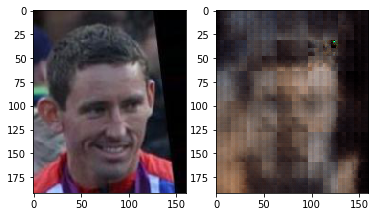

	Epoch 0 batch 1500 gen total loss: 0.8898136081695557 mse loss: 0.16733243227005004 kld loss: 0.0 xe loss: 0.7224811749458313 disc loss: 1.3712190726995468 disc acc: 0.5353333373218775
	Epoch 0 batch 2000 gen total loss: 0.8903277381658554 mse loss: 0.16787598729133607 kld loss: 0.0 xe loss: 0.722451749920845 disc loss: 1.3620257329940797 disc acc: 0.5284444483816624


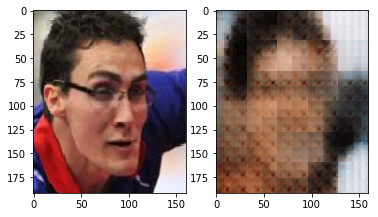

	Epoch 0 batch 2500 gen total loss: 0.8882269304990769 mse loss: 0.1694319702088833 kld loss: 0.0 xe loss: 0.7187949604988099 disc loss: 1.3706158903837204 disc acc: 0.5108888926953077
	Epoch 0 batch 3000 gen total loss: 0.8826088440418244 mse loss: 0.15622495791316032 kld loss: 0.0 xe loss: 0.7263838864564895 disc loss: 1.3515862154960632 disc acc: 0.5490000040903688


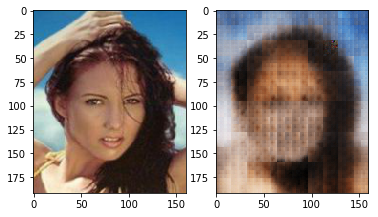

	Epoch 0 batch 3500 gen total loss: 0.8815950248241424 mse loss: 0.16548796337842941 kld loss: 0.0 xe loss: 0.7161070615053177 disc loss: 1.3764298815727234 disc acc: 0.49966667038947343
	Epoch 0 batch 4000 gen total loss: 0.8700313977003098 mse loss: 0.15795511731505393 kld loss: 0.0 xe loss: 0.7120762816667556 disc loss: 1.3658599112033845 disc acc: 0.5090000037923456


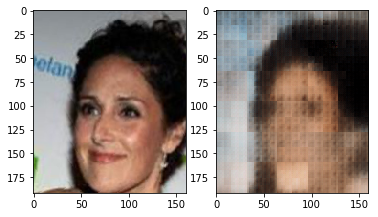

	Epoch 0 batch 4500 gen total loss: 0.8794139878749847 mse loss: 0.164787664860487 kld loss: 0.0 xe loss: 0.7146263231039047 disc loss: 1.3631012743711473 disc acc: 0.512666670486331
	Epoch 0 batch 5000 gen total loss: 0.8827547281980515 mse loss: 0.16660661643743516 kld loss: 0.0 xe loss: 0.7161481138467789 disc loss: 1.3492813153266907 disc acc: 0.5320000039637088


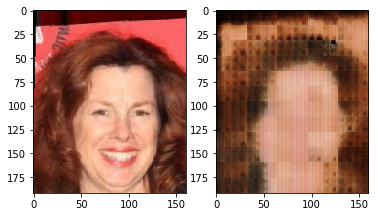

	Epoch 0 batch 5500 gen total loss: 0.8858331454992294 mse loss: 0.17304519924521447 kld loss: 0.0 xe loss: 0.7127879453897477 disc loss: 1.3544292377233504 disc acc: 0.5177777816355228
	Epoch 0 batch 6000 gen total loss: 0.8783532853126526 mse loss: 0.16748287749290466 kld loss: 0.0 xe loss: 0.7108704081773758 disc loss: 1.3590931166410447 disc acc: 0.4994444481655955


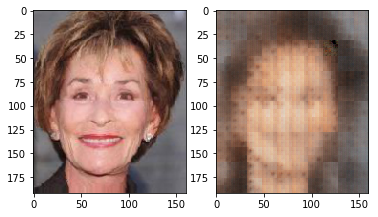

	Epoch 0 batch 6500 gen total loss: 0.8695547466278076 mse loss: 0.1591706338226795 kld loss: 0.0 xe loss: 0.7103841121196747 disc loss: 1.3595223873853683 disc acc: 0.5041111148670315
	Epoch 0 batch 7000 gen total loss: 0.853942144870758 mse loss: 0.14444306176900865 kld loss: 0.0 xe loss: 0.7094990835189819 disc loss: 1.3515105652809143 disc acc: 0.5122222260385751


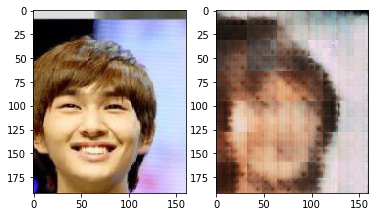

	Epoch 0 batch 7500 gen total loss: 0.8740472072362899 mse loss: 0.16483381313085557 kld loss: 0.0 xe loss: 0.709213392496109 disc loss: 1.3580283209085464 disc acc: 0.5128888927102089
	Epoch 0 batch 8000 gen total loss: 0.8620305557250977 mse loss: 0.15275484332442282 kld loss: 0.0 xe loss: 0.7092757133245469 disc loss: 1.3559985755681991 disc acc: 0.5064444482177496


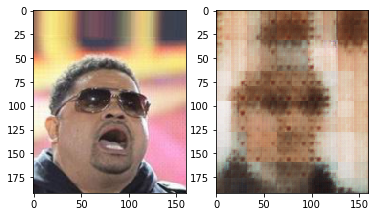

	Epoch 0 batch 8500 gen total loss: 0.8644816672801972 mse loss: 0.15854448348283767 kld loss: 0.0 xe loss: 0.7059371831417084 disc loss: 1.3528999732732774 disc acc: 0.5104444482475519
	Epoch 0 batch 9000 gen total loss: 0.8603060462474823 mse loss: 0.15164127352833748 kld loss: 0.0 xe loss: 0.7086647726297378 disc loss: 1.3545206645727157 disc acc: 0.5112222260311245


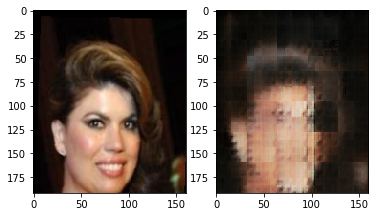

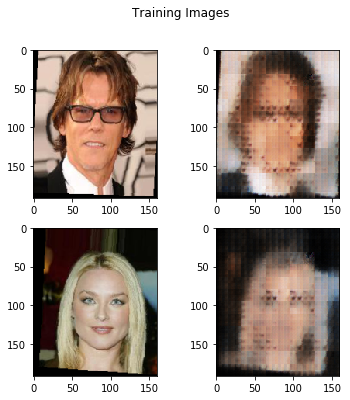

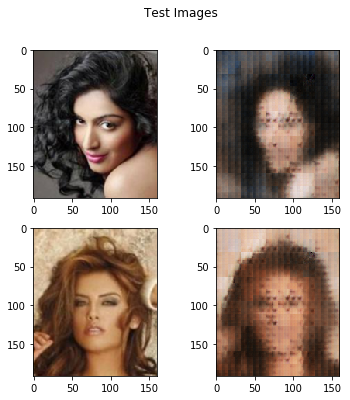

Epoch: 0 Gen Train Loss: 0.8795565417144091 MSE Loss: 0.16287214734219496 KLD Loss: 0.0 Mean GAN XE Loss: 0.7166843943175722 Disc Train Loss: 1.371391437885801 Test Loss: 0.16484548506455693 Avg Tr Disc Acc: 0.5179081622332758 Avg Te Disc Acc: 0.5486619404554973
Copying file://gen_model_3.pt [Content-Type=application/octet-stream]...
==> NOTE: You are uploading one or more large file(s), which would run
significantly faster if you enable parallel composite uploads. This
feature can be enabled by editing the
"parallel_composite_upload_threshold" value in your .boto
configuration file. However, note that if you do this large files will
be uploaded as `composite objects
<https://cloud.google.com/storage/docs/composite-objects>`_,which
means that any user who downloads such objects will need to have a
compiled crcmod installed (see "gsutil help crcmod"). This is because
without a compiled crcmod, computing checksums on composite objects is
so slow that gsutil disables downloads of composit

In [0]:
train_gan(discriminator, generator, train_loader, d_optimizer, g_optimizer, print_metrics=500, plot_images=1000, num_epochs=1, extra_gen_train=16, test_loader=test_loader, separate_batches=True, g_scheduler=g_scheduler, d_scheduler=d_scheduler, d_save_path="disc_model_3.pt", g_save_path="gen_model_3.pt")

	Epoch 1 batch 1000 gen total loss: 0.8626210277676583 mse loss: 0.15460197479277848 kld loss: 0.0 xe loss: 0.7080190533399582 disc loss: 1.3697307462096213 disc acc: 0.5153333371728659
	Epoch 1 batch 2000 gen total loss: 0.8713057192564011 mse loss: 0.16064473102986812 kld loss: 0.0 xe loss: 0.7106609877347946 disc loss: 1.3639067559838296 disc acc: 0.5236666705682874


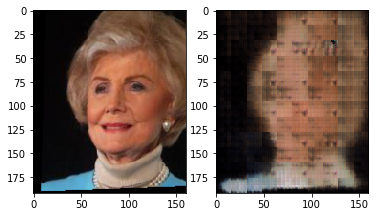

	Epoch 1 batch 3000 gen total loss: 0.8954401395916939 mse loss: 0.1744268053472042 kld loss: 0.0 xe loss: 0.7210133337378501 disc loss: 1.3540987018346786 disc acc: 0.5397222262434661
	Epoch 1 batch 4000 gen total loss: 0.8892516577243805 mse loss: 0.17545449218153952 kld loss: 0.0 xe loss: 0.713797165453434 disc loss: 1.3592006373405456 disc acc: 0.5334444484189153


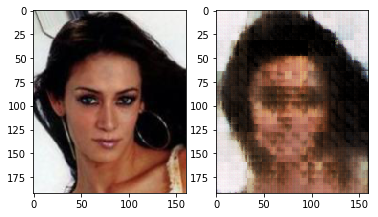

	Epoch 1 batch 5000 gen total loss: 0.9231752306222916 mse loss: 0.19145747974514962 kld loss: 0.0 xe loss: 0.7317177503108978 disc loss: 1.341815521478653 disc acc: 0.5629444486387074
	Epoch 1 batch 6000 gen total loss: 0.9010959621667862 mse loss: 0.18035155668854713 kld loss: 0.0 xe loss: 0.7207444052696228 disc loss: 1.3526428868174554 disc acc: 0.5462777818478644


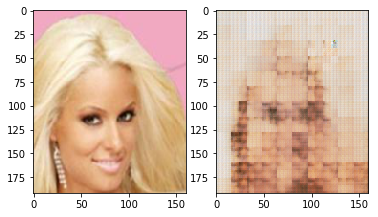

	Epoch 1 batch 7000 gen total loss: 0.8805308375954628 mse loss: 0.16414609298110008 kld loss: 0.0 xe loss: 0.716384745657444 disc loss: 1.3568549937605858 disc acc: 0.5389444484598934
	Epoch 1 batch 8000 gen total loss: 0.908097125351429 mse loss: 0.18079875759780406 kld loss: 0.0 xe loss: 0.7272983675599098 disc loss: 1.3411217170357703 disc acc: 0.5587222263850272


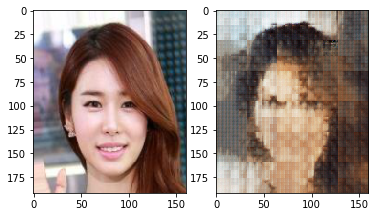

	Epoch 1 batch 9000 gen total loss: 0.9732891041636467 mse loss: 0.20220220878720283 kld loss: 0.0 xe loss: 0.771086894094944 disc loss: 1.2860991574525833 disc acc: 0.6288888935744762


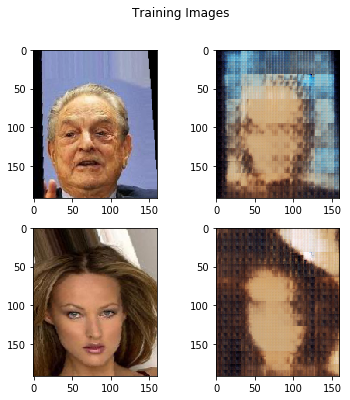

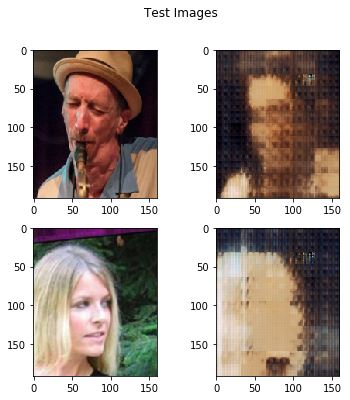

Epoch: 1 Gen Train Loss: 0.9063052099914876 MSE Loss: 0.17910038650990484 KLD Loss: 0.0 Mean GAN XE Loss: 0.7272048233152465 Disc Train Loss: 1.3437903068374724 Test Loss: 0.25800695219417896 Avg Tr Disc Acc: 0.5539018352077253 Avg Te Disc Acc: 0.5433519809506834
Copying file://gen_model_3.pt [Content-Type=application/octet-stream]...
==> NOTE: You are uploading one or more large file(s), which would run
significantly faster if you enable parallel composite uploads. This
feature can be enabled by editing the
"parallel_composite_upload_threshold" value in your .boto
configuration file. However, note that if you do this large files will
be uploaded as `composite objects
<https://cloud.google.com/storage/docs/composite-objects>`_,which
means that any user who downloads such objects will need to have a
compiled crcmod installed (see "gsutil help crcmod"). This is because
without a compiled crcmod, computing checksums on composite objects is
so slow that gsutil disables downloads of composi

In [14]:
train_gan(discriminator, generator, train_loader, d_optimizer, g_optimizer, print_metrics=1000, plot_images=2000, num_epochs=1, extra_gen_train=32, test_loader=test_loader, separate_batches=True, g_scheduler=g_scheduler, d_scheduler=d_scheduler, d_save_path="disc_model_3.pt", g_save_path="gen_model_3.pt")

	Epoch 0 batch 1000 gen total loss: 0.921429640352726 mse loss: 0.20844225633144378 kld loss: 0.0 xe loss: 0.7129873855710029 disc loss: 1.385373325228691 disc acc: 0.5158333371765912
	Epoch 0 batch 2000 gen total loss: 0.872991830587387 mse loss: 0.1678408076092601 kld loss: 0.0 xe loss: 0.7051510237455368 disc loss: 1.3821605092287064 disc acc: 0.5201666705422103


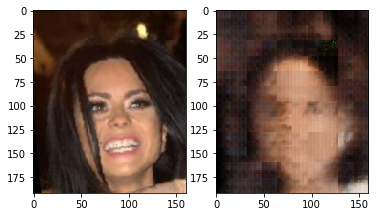

	Epoch 0 batch 3000 gen total loss: 0.8772807387113571 mse loss: 0.16146041021496058 kld loss: 0.0 xe loss: 0.7158203282356262 disc loss: 1.3781111289858818 disc acc: 0.5165555594041944
	Epoch 0 batch 4000 gen total loss: 0.9703703224658966 mse loss: 0.21353688149154187 kld loss: 0.0 xe loss: 0.7568334399461746 disc loss: 1.31695293790102 disc acc: 0.6096666712090373


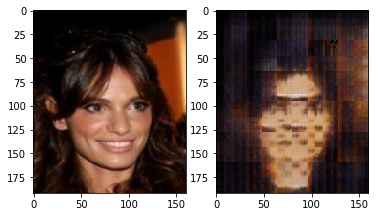

	Epoch 0 batch 5000 gen total loss: 1.0231511739492416 mse loss: 0.253767789170146 kld loss: 0.0 xe loss: 0.7693833853006363 disc loss: 1.315261197268963 disc acc: 0.6241666713170707
	Epoch 0 batch 6000 gen total loss: 0.9499975473880767 mse loss: 0.22437097439169884 kld loss: 0.0 xe loss: 0.7256265732049942 disc loss: 1.3602082340717316 disc acc: 0.5558888930305839


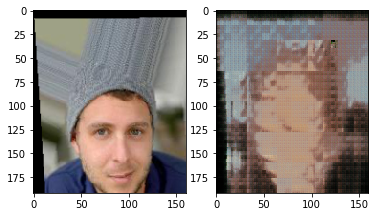

	Epoch 0 batch 7000 gen total loss: 0.8956132863163948 mse loss: 0.17426415053009986 kld loss: 0.0 xe loss: 0.7213491361141204 disc loss: 1.3770432322621347 disc acc: 0.5271111150383949
	Epoch 0 batch 8000 gen total loss: 1.0135438988208771 mse loss: 0.2265316976159811 kld loss: 0.0 xe loss: 0.7870122010111809 disc loss: 1.2819500424861907 disc acc: 0.6428888936787843


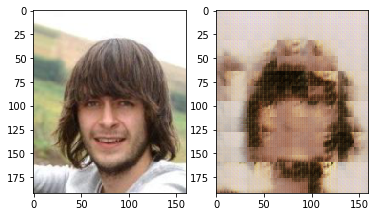

	Epoch 0 batch 9000 gen total loss: 1.1051759670376777 mse loss: 0.29017274601757526 kld loss: 0.0 xe loss: 0.8150032215118408 disc loss: 1.263773483812809 disc acc: 0.6560555604435504


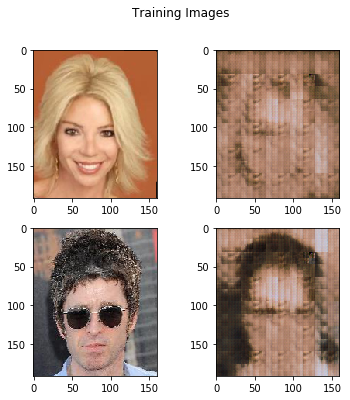

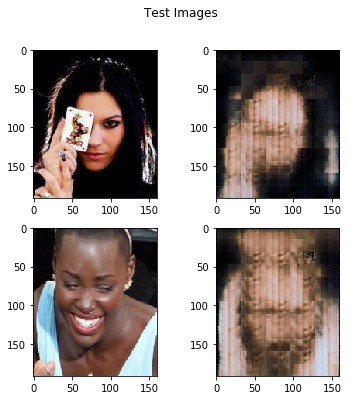

Epoch: 0 Gen Train Loss: 0.9680782317202393 MSE Loss: 0.2159792970853108 KLD Loss: 0.0 Mean GAN XE Loss: 0.7520989349065308 Disc Train Loss: 1.330529847690985 Test Loss: 0.32043227570328287 Avg Tr Disc Acc: 0.582712591821818 Avg Te Disc Acc: 0.13338415031359205
Copying file://gen_model_3.pt [Content-Type=application/octet-stream]...
==> NOTE: You are uploading one or more large file(s), which would run
significantly faster if you enable parallel composite uploads. This
feature can be enabled by editing the
"parallel_composite_upload_threshold" value in your .boto
configuration file. However, note that if you do this large files will
be uploaded as `composite objects
<https://cloud.google.com/storage/docs/composite-objects>`_,which
means that any user who downloads such objects will need to have a
compiled crcmod installed (see "gsutil help crcmod"). This is because
without a compiled crcmod, computing checksums on composite objects is
so slow that gsutil disables downloads of composite

In [10]:
train_gan(discriminator, generator, train_loader, d_optimizer, g_optimizer, print_metrics=1000, plot_images=2000, num_epochs=1, extra_gen_train=64, test_loader=test_loader, separate_batches=True, g_scheduler=g_scheduler, d_scheduler=d_scheduler, d_save_path="disc_model_3.pt", g_save_path="gen_model_3.pt")

	Epoch 1 batch 500 gen total loss: 1.1870319912433624 mse loss: 0.4263458331823349 kld loss: 0.0 xe loss: 0.7606861550211906 disc loss: 1.31634171128273 disc acc: 0.608000004529953
	Epoch 1 batch 1000 gen total loss: 1.1812505432367324 mse loss: 0.42529142570495604 kld loss: 0.0 xe loss: 0.7559591176509857 disc loss: 1.3787272989749908 disc acc: 0.5591111152768135
	Epoch 1 batch 1500 gen total loss: 1.1015854014158248 mse loss: 0.36901748698949816 kld loss: 0.0 xe loss: 0.7325679141879081 disc loss: 1.3912488095760345 disc acc: 0.5424444484859705
	Epoch 1 batch 2000 gen total loss: 1.074735451579094 mse loss: 0.345752150118351 kld loss: 0.0 xe loss: 0.7289832999706268 disc loss: 1.3920195254087449 disc acc: 0.5338888928666711


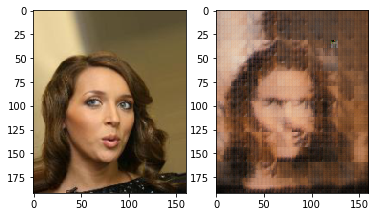

	Epoch 1 batch 2500 gen total loss: 1.0926721366643906 mse loss: 0.35671635258197787 kld loss: 0.0 xe loss: 0.7359557836055756 disc loss: 1.3834742970466614 disc acc: 0.534111115090549
	Epoch 1 batch 3000 gen total loss: 1.112153949856758 mse loss: 0.3658825719356537 kld loss: 0.0 xe loss: 0.7462713762521743 disc loss: 1.3656955497264862 disc acc: 0.5536666707918048
	Epoch 1 batch 3500 gen total loss: 1.4483318696022034 mse loss: 0.38502003091573717 kld loss: 0.0 xe loss: 1.0633118382692337 disc loss: 0.9183063269853592 disc acc: 0.9048888956308365
	Epoch 1 batch 4000 gen total loss: 1.737678934931755 mse loss: 0.40664897936582567 kld loss: 0.0 xe loss: 1.33102995967865 disc loss: 0.7584141435623168 disc acc: 0.9383333403244615


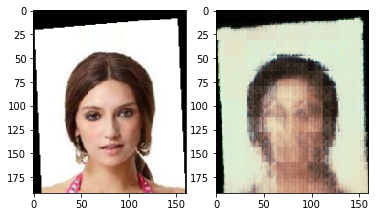

	Epoch 1 batch 4500 gen total loss: 1.8420292990207672 mse loss: 0.33088811028003695 kld loss: 0.0 xe loss: 1.5111411885023116 disc loss: 0.5570228356719017 disc acc: 0.9758888961598277
	Epoch 1 batch 5000 gen total loss: 2.1256690850257876 mse loss: 0.4559190501570702 kld loss: 0.0 xe loss: 1.6697500357031823 disc loss: 0.5712022450566292 disc acc: 0.9295555624812841
	Epoch 1 batch 5500 gen total loss: 1.9689101409912109 mse loss: 0.6970480133891106 kld loss: 0.0 xe loss: 1.2718621321916581 disc loss: 0.9006415719389915 disc acc: 0.8335555617660284
	Epoch 1 batch 6000 gen total loss: 1.9598526432514192 mse loss: 0.605599203824997 kld loss: 0.0 xe loss: 1.354253439128399 disc loss: 0.9166036229729653 disc acc: 0.8221111172363162


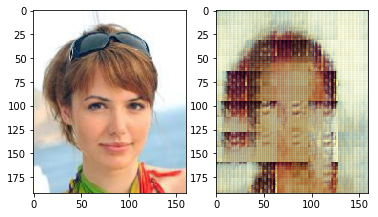

	Epoch 1 batch 6500 gen total loss: 1.6200519301891327 mse loss: 0.7078974112272263 kld loss: 0.0 xe loss: 0.9121545189023018 disc loss: 1.3601426048278809 disc acc: 0.6044444489479065
	Epoch 1 batch 7000 gen total loss: 1.6592526803016663 mse loss: 0.6522876735925675 kld loss: 0.0 xe loss: 1.0069650104045869 disc loss: 1.2158167877197266 disc acc: 0.6808888939619064
	Epoch 1 batch 7500 gen total loss: 1.4542427456378937 mse loss: 0.5739640604257583 kld loss: 0.0 xe loss: 0.8802786837220192 disc loss: 1.4137295882701875 disc acc: 0.5660000042170286
	Epoch 1 batch 8000 gen total loss: 1.5415971401929855 mse loss: 0.6261338742971421 kld loss: 0.0 xe loss: 0.9154632635712624 disc loss: 1.3367610268592836 disc acc: 0.6045555600598455


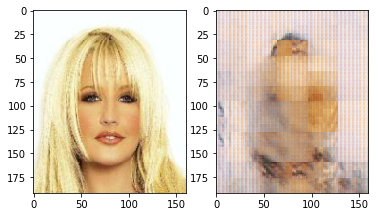

	Epoch 1 batch 8500 gen total loss: 1.1600363039970398 mse loss: 0.4074416161775589 kld loss: 0.0 xe loss: 0.752594687461853 disc loss: 1.4545174117088318 disc acc: 0.5233333372324706
	Epoch 1 batch 9000 gen total loss: 1.1507617123126983 mse loss: 0.4034569661617279 kld loss: 0.0 xe loss: 0.7473047432303429 disc loss: 1.460626821756363 disc acc: 0.5027777815237642


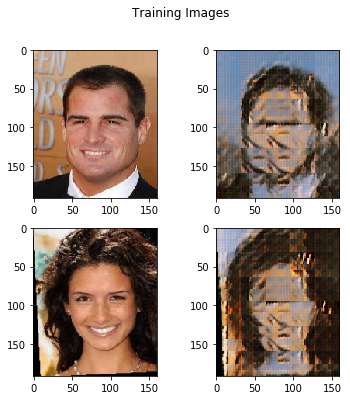

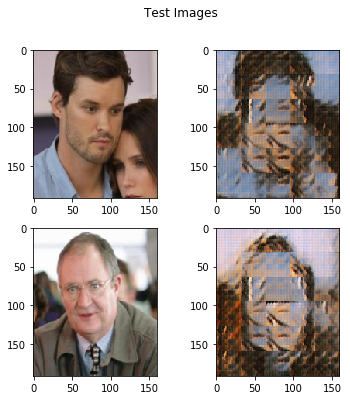

Epoch: 1 Gen Train Loss: 1.4703988352914223 MSE Loss: 0.47709076754858104 KLD Loss: 0.0 Mean GAN XE Loss: 0.9933080677283772 Disc Train Loss: 1.1689368592956078 Test Loss: 0.6835153533191216 Avg Tr Disc Acc: 0.6804237420083288 Avg Te Disc Acc: 0.5155233893414762
Copying file://gen_model_3.pt [Content-Type=application/octet-stream]...
==> NOTE: You are uploading one or more large file(s), which would run
significantly faster if you enable parallel composite uploads. This
feature can be enabled by editing the
"parallel_composite_upload_threshold" value in your .boto
configuration file. However, note that if you do this large files will
be uploaded as `composite objects
<https://cloud.google.com/storage/docs/composite-objects>`_,which
means that any user who downloads such objects will need to have a
compiled crcmod installed (see "gsutil help crcmod"). This is because
without a compiled crcmod, computing checksums on composite objects is
so slow that gsutil disables downloads of composit

In [22]:
train_gan(discriminator, generator, train_loader, d_optimizer, g_optimizer, print_metrics=500, plot_images=2000, num_epochs=1, extra_gen_train=128, test_loader=test_loader, separate_batches=True, g_scheduler=g_scheduler, d_scheduler=d_scheduler, d_save_path="disc_model_3.pt", g_save_path="gen_model_3.pt")

In [0]:
train_gan(discriminator, generator, train_loader, d_optimizer, g_optimizer, print_metrics=1000, plot_images=2000, num_epochs=1, extra_gen_train=256, test_loader=test_loader, separate_batches=True, g_scheduler=g_scheduler, d_scheduler=d_scheduler, d_save_path="disc_model_3.pt", g_save_path="gen_model_3.pt")

Accuracy: tensor(0.5556, device='cuda:0')
0.4403845965862274


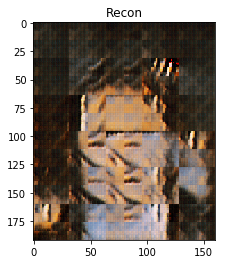

0.6519516110420227


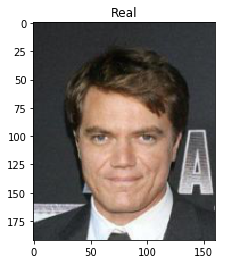

In [23]:
# check that the discriminator is working properly
with torch.no_grad():
    for (inputs, _) in train_loader:
        generator.eval()
        
        recon, mu, logvar = generator(inputs.cuda())
        
        # feed the original images to the discriminator
        real_probs = torch.sigmoid(discriminator(inputs.cuda()))
        fake_probs = torch.sigmoid(discriminator(recon))
        
        probs = torch.cat((real_probs, fake_probs), 0).float()
        labels = torch.cat((torch.ones(inputs.shape[0]), torch.zeros(inputs.shape[0])), 0).cuda()
        
        print("Accuracy:", torch.mean((torch.round(probs) == labels).float()))
        print(fake_probs[0].item())
        plt.imshow(recon[0].cpu().permute(1,2,0))
        plt.title("Recon")
        plt.show()
        
        print(real_probs[0].item())
        plt.imshow(inputs[0].cpu().permute(1,2,0))
        plt.title("Real")
        plt.show()
        
        break

In [0]:
for (image, label) in zip(disc_batch, d_preds):
    plt.imshow(image.detach().cpu().permute(1, 2, 0))
    plt.title(str(label))
    plt.show()

In [0]:
inputs = torch.autograd.Variable(recon.clone().cuda(), requires_grad=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


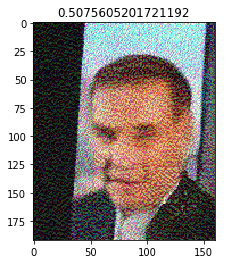

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


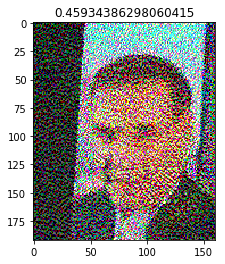

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


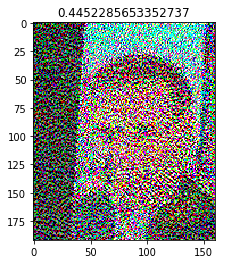

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


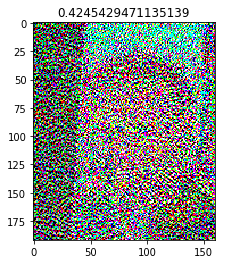

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


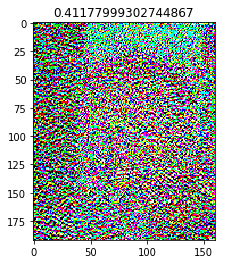

KeyboardInterrupt: ignored

In [0]:
# create a random tensor of the proper size
# inputs = torch.autograd.Variable(torch.randn(2, 3, 192, 160).cuda(), requires_grad=True)

# create an optimizer for our images
r_opt = optim.Adam([inputs], lr=0.001)

# loss function is we want the images to be predicted as real
def rev_loss(d_faked):
    labels = torch.ones(d_faked.shape[0]).cuda()
#     labels = torch.zeros(d_faked.shape[0]).cuda()
    d_loss = nn.functional.binary_cross_entropy_with_logits(d_faked, labels, reduction="mean")
    
    return d_loss

# discriminator.eval()  
  
for j in range(10):  
  losses = []
  for i in range(200):
      logits = discriminator(inputs)
      loss = rev_loss(logits)
#       print(loss.item())
      loss.backward()
      r_opt.step()
      losses.append(loss.item())
      
  plt.imshow(inputs[0].detach().cpu().permute(1, 2, 0) )
  plt.title(str(np.mean(losses)))
  plt.show()

In [0]:
## CHECK MEAN AND VARIANCE OF CODES
with torch.no_grad():
    for (inputs, _) in test_loader:
      generator.encoder.eval()
      generator.decoder.eval()
      # encode the images and reconstruct them
      codes, logvar = generator.encoder(inputs.cuda())
      print("Mean:", torch.mean(codes))
      print("Std:", codes.std())
      recon = generator.decoder(codes)
      d_faked = discriminator(recon)
      print("Faked Logits Mean:", d_faked.mean())
      vae_loss(inputs.cuda(), recon, codes, logvar=logvar, d_faked = d_faked, debug = True)
      break

Mean: tensor(-0.0188, device='cuda:0')
Std: tensor(3.1603, device='cuda:0')
Faked Logits Mean: tensor(0.0726, device='cuda:0')
MSE Loss Raw: tensor(0.0024, device='cuda:0')
MSE Loss Weighted: tensor(0.4753, device='cuda:0')
KLD Loss Raw: tensor([0.])
KLD Loss Weighted: tensor([0.])
Disc Loss Raw: tensor(0.7382, device='cuda:0')
Disc Loss Weighted: tensor(0.1476, device='cuda:0')
Total Loss (weighted): tensor(0.6230, device='cuda:0')


#### Additional Training on Personal Images

In [0]:
!mkdir data/Train
!cp -r data/images/Training_Pictures data/Train/Images

In [0]:
train_dataset2 = torchvision.datasets.ImageFolder(
        root="data/Train",
        transform=transform
    )

train_loader2 = torch.utils.data.DataLoader(
    train_dataset2,
    batch_size=BATCH_SIZE,
    num_workers=2,
    shuffle=True
)

In [0]:
train_discriminator(discriminator, generator, train_loader2, d_optimizer, g_optimizer, test_loader=train_loader2, num_epochs=5, print_metrics=1000, extra_gen_train=2, plot_images=2000, train_gen=True, train_disc=True, g_scheduler=g_scheduler, d_scheduler=d_scheduler, d_save_path="disc_model_3.pt", g_save_path="model_3g.pt")

RuntimeError: ignored

In [0]:
noise = np.random.normal(loc=0.3, scale=7.5, size=4096).reshape((1,4096,1,1))
image = model.decoder(torch.from_numpy(noise).cuda().float())
plt.imshow(image[0].cpu().detach().permute(1,2,0))
plt.show()

#### Additional Training on Specific Images

In [0]:
# # download and unzip the data
# url = "https://s3.eu-west-3.amazonaws.com/deep.skoo.ch/GWB_64x64.zip"
# if not os.path.exists("gwb_images.zip"):
#   wget.download(url, 'gwb_images.zip')

#   zip_ref = zipfile.ZipFile('gwb_images.zip', 'r')
#   zip_ref.extractall('data/gwb')
#   zip_ref.close()

In [0]:
# use the existing encoder to create a GWBush decoder
from torch import optim
import numpy as np

  ## YOUR CODE HERE ##
encoder = model.encoder
gwb_decoder = Decoder(2048)
gwb_model = SingleModel(encoder, gwb_decoder)
gwb_params = gwb_model.decoder.parameters()

# run on GPU
use_cuda = True

if use_cuda and torch.cuda.is_available():
    encoder.cuda()
    gwb_decoder.cuda()
    gwb_model.cuda()
    
optimizer = optim.Adam(gwb_params, lr=0.002)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)    

In [0]:
# gwb dataset
BATCH_SIZE = 64
data_path = "data/gwb"

transform = torchvision.transforms.Compose(
    [torchvision.transforms.RandomHorizontalFlip(p=0.5), 
      torchvision.transforms.RandomChoice([
        torchvision.transforms.RandomAffine(degrees=7, translate=(0.05,0.05), scale=(0.9,1.1), shear=3, resample=False, fillcolor=0),
        torchvision.transforms.RandomResizedCrop((192,160), scale=(0.90, 1.1)),
      ]),
    torchvision.transforms.ToTensor(),
    ])

gwb_train_dataset = torchvision.datasets.ImageFolder(
        root=data_path,
        transform=transform
    )

gwb_train_loader2 = torch.utils.data.DataLoader(
    gwb_train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True
)

In [0]:
for (images, _) in gwb_train_loader2:
  plt.imshow(images[0].permute(1,2,0))
  break

In [0]:
train(gwb_model, gwb_train_loader2, optimizer, print_metrics=0, num_epochs=200, display_images=20, scheduler=scheduler, save_path="./gwb_model.pt")